In [56]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [57]:
train_df = pd.read_csv('/content/drive/MyDrive/Research_SEM4/Dataset/train.csv')
dev_df = pd.read_csv('/content/drive/MyDrive/Research_SEM4/Dataset/dev.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Research_SEM4/Dataset/test.csv')

In [58]:
train_df.iloc[1]

,1
id,116936
url,https://www.liputan6.com/news/read/116936/-i-n...
article,"Liputan6. com, Jakarta: Earth Wind and Fire Ex..."
summary,Pertunjukan ini adalah penampilan kedua dari r...


In [59]:
dev_df.iloc[1]

,1
id,2833
url,https://www.liputan6.com/news/read/2833/pajak-...
article,"Liputan6. com, Jakarta: Gubernur DKI Jakarta S..."
summary,Guna meningkatkan Pendapatan Asli Daerah DKI J...


In [60]:
test_df.iloc[1]

,1
id,24141
url,https://www.liputan6.com/news/read/24141/busun...
article,"Liputan6. com, Bandar Lampung: Sebanyak 51 ana..."
summary,"Liputan6. com, Bandar Lampung: Sebanyak 51 ana..."


In [61]:
train_df = train_df.drop(['id', 'url'], axis=1)
test_df = test_df.drop(['id', 'url'], axis=1)
dev_df = dev_df.drop(['id', 'url'], axis=1)

train_df = train_df.rename(columns={"article": "original_text"})
train_df = train_df.rename(columns={"summary": "extractive_summary"})

test_df = test_df.rename(columns={"article": "original_text"})
test_df = test_df.rename(columns={"summary": "extractive_summary"})

dev_df = dev_df.rename(columns={"article": "original_text"})
dev_df = dev_df.rename(columns={"summary": "extractive_summary"})

In [62]:
train_df.shape

(193883, 2)

In [63]:
dev_df.shape

(10971, 2)

In [64]:
test_df.shape

(10972, 2)

In [65]:


whitespace_re = re.compile(r'\s+')
hashtag_split_re = re.compile(r'#(\w+)')
camel_case_re = re.compile(r'(?<=[a-z0-9])(?=[A-Z])')
liputan_re = re.compile(r'\bliputan6\s*\.?\s*com\b', flags=re.IGNORECASE)
special_char_re = re.compile(r'[^\w\s]')

def clean_text(text):
    text = whitespace_re.sub(' ', text).strip()

    text = liputan_re.sub(' ', text)

    text = hashtag_split_re.sub(lambda m: ' ' + camel_case_re.sub(' ', m.group(1)), text)

    text = text.lower()

    text = special_char_re.sub(' ', text)

    return text


def apply_cleaning(dfs, columns):
    for df in dfs:
        for col in columns:
            df[col] = df[col].astype(str).apply(clean_text)

apply_cleaning(
    dfs=[train_df, test_df, dev_df],
    columns=['original_text', 'extractive_summary']
)

In [66]:
train_df.head()

,original_text,extractive_summary
0,tiga kali somasi dilayangkan kepada nuri shade...,tiga kali somasi dilayangkan kepada nuri shade...
1,jakarta earth wind and fire experience wor...,pertunjukan ini adalah penampilan kedua dari r...
2,jakarta belasan unit mobil pemadam kebakar...,api di lokasi kebakaran yang berjarak beberapa...
3,empat tahun silam ballack terpaksa duduk di b...,empat tahun silam ballack terpaksa duduk di b...
4,bandung ruthini anggota pondok nabi belum...,piator mengaku tidak mengetahui anaknya menjad...


In [67]:
dev_df.head()

,original_text,extractive_summary
0,jakarta keinginan untuk menindaklanjuti ha...,buktinya beberapa anggota dpr ngebet membentu...
1,jakarta gubernur dki jakarta sutiyoso meng...,guna meningkatkan pendapatan asli daerah dki j...
2,jakarta sejumlah mobil yang terjebak di ru...,mobil yang boleh diambil adalah mobil yang ber...
3,medan kepolisian daerah sumatera utara mer...,medan kepolisian daerah sumatera utara mer...
4,jakarta ratusan mobil selundupan yang berh...,sebagian besar mobil mewah bekas yang akan dil...


In [68]:
test_df.head()

,original_text,extractive_summary
0,bangka kapal patroli angkatan laut republi...,ketiga kapal itu ditangkap karena melanggar zo...
1,bandar lampung sebanyak 51 anak di bawah u...,bandar lampung sebanyak 51 anak di bawah u...
2,jakarta polemik seputar pelaksanaan sidang...,setelah sekian kali presiden abdurrahman wahi...
3,ambon bahan bakar minyak jenis solar dan p...,ambon bahan bakar minyak jenis solar dan p...
4,jakarta seluruh perubahan pasal undang und...,inti pasal itu adalah soal memberhentikan selu...


In [69]:
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column].apply(len)))
    return df[z_scores < threshold]

def remove_outliers_std(df, column, n_std=2):
    mean_length = df[column].apply(len).mean()
    std_length = df[column].apply(len).std()

    return df[
        (df[column].apply(len) >= mean_length - n_std * std_length) &
        (df[column].apply(len) <= mean_length + n_std * std_length)
    ]

def compare_outlier_removal_methods(df, column):
    # Hitung IQR
    Q1 = df[column].apply(len).quantile(0.25)
    Q3 = df[column].apply(len).quantile(0.75)
    IQR = Q3 - Q1

    methods = {
        'IQR Method': len(df) - len(df[
            (df[column].apply(len) >= Q1 - 1.5 * IQR) &
            (df[column].apply(len) <= Q3 + 1.5 * IQR)
        ]),
        'Z-Score Method': len(df) - len(remove_outliers_zscore(df, column)),
        'Percentile Method': len(df) - len(df[
            (df[column].apply(len) >= df[column].apply(len).quantile(0.01)) &
            (df[column].apply(len) <= df[column].apply(len).quantile(0.99))
        ]),
        'Standard Deviation': len(df) - len(remove_outliers_std(df, column)),
        'Absolute Threshold (10-1000)': len(df) - len(df[
            (df[column].apply(len) >= 10) &
            (df[column].apply(len) <= 1000)
        ])
    }

    return methods

outliers_count = compare_outlier_removal_methods(train_df, 'original_text')
print("\nPerbandingan Metode Removal Outliers:")
for method, count in outliers_count.items():
    print(f"{method}: {count} outliers ({count/len(train_df)*100:.2f}%)")


Perbandingan Metode Removal Outliers:
IQR Method: 9179 outliers (4.73%)
Z-Score Method: 2923 outliers (1.51%)
Percentile Method: 3849 outliers (1.99%)
Standard Deviation: 6644 outliers (3.43%)
Absolute Threshold (10-1000): 124259 outliers (64.09%)


In [70]:
sample_train_df = train_df.sample(n=25000, random_state=42)
sample_dev_df = dev_df.sample(n=3125, random_state=42)
sample_test_df = test_df.sample(n=3125, random_state=42)

In [71]:
def count_words(text):
    return len(str(text).split())

def calculate_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def compute_outlier_bounds_from_df(df, columns):
    bounds = {}
    for col in columns:
        df[f'{col}_words'] = df[col].apply(count_words)
        bounds[col] = calculate_outlier_bounds(df[f'{col}_words'])
    return bounds

def apply_outlier_filter(df, columns, bounds):
    for col in columns:
        df[f'{col}_words'] = df[col].apply(count_words)

    mask = pd.Series(True, index=df.index)
    for col in columns:
        lower, upper = bounds[col]
        mask &= df[f'{col}_words'].between(lower, upper)

    clean_df = df[mask].copy()
    outliers_df = df[~mask].copy()

    for col in columns:
        clean_df.drop(f'{col}_words', axis=1, inplace=True)
        outliers_df.drop(f'{col}_words', axis=1, inplace=True)

    return clean_df, outliers_df

def plot_word_distributions(original_df, cleaned_df, columns):
    fig, axes = plt.subplots(len(columns), 2, figsize=(15, 5*len(columns)))

    for i, col in enumerate(columns):
        # Before cleaning
        original_df[col].apply(count_words).hist(
            ax=axes[i,0], bins=50, alpha=0.5
        )
        axes[i,0].set_title(f'{col} - Before Cleaning')

        # After cleaning
        cleaned_df[col].apply(count_words).hist(
            ax=axes[i,1], bins=50, alpha=0.5
        )
        axes[i,1].set_title(f'{col} - After Cleaning')

    plt.tight_layout()
    plt.show()

Train original: (25000, 4), Cleaned: (23220, 2), Removed: 1780
Dev original: (3125, 4), Cleaned: (3004, 2), Removed: 121
Test original: (3125, 4), Cleaned: (3032, 2), Removed: 93
Train Dataset


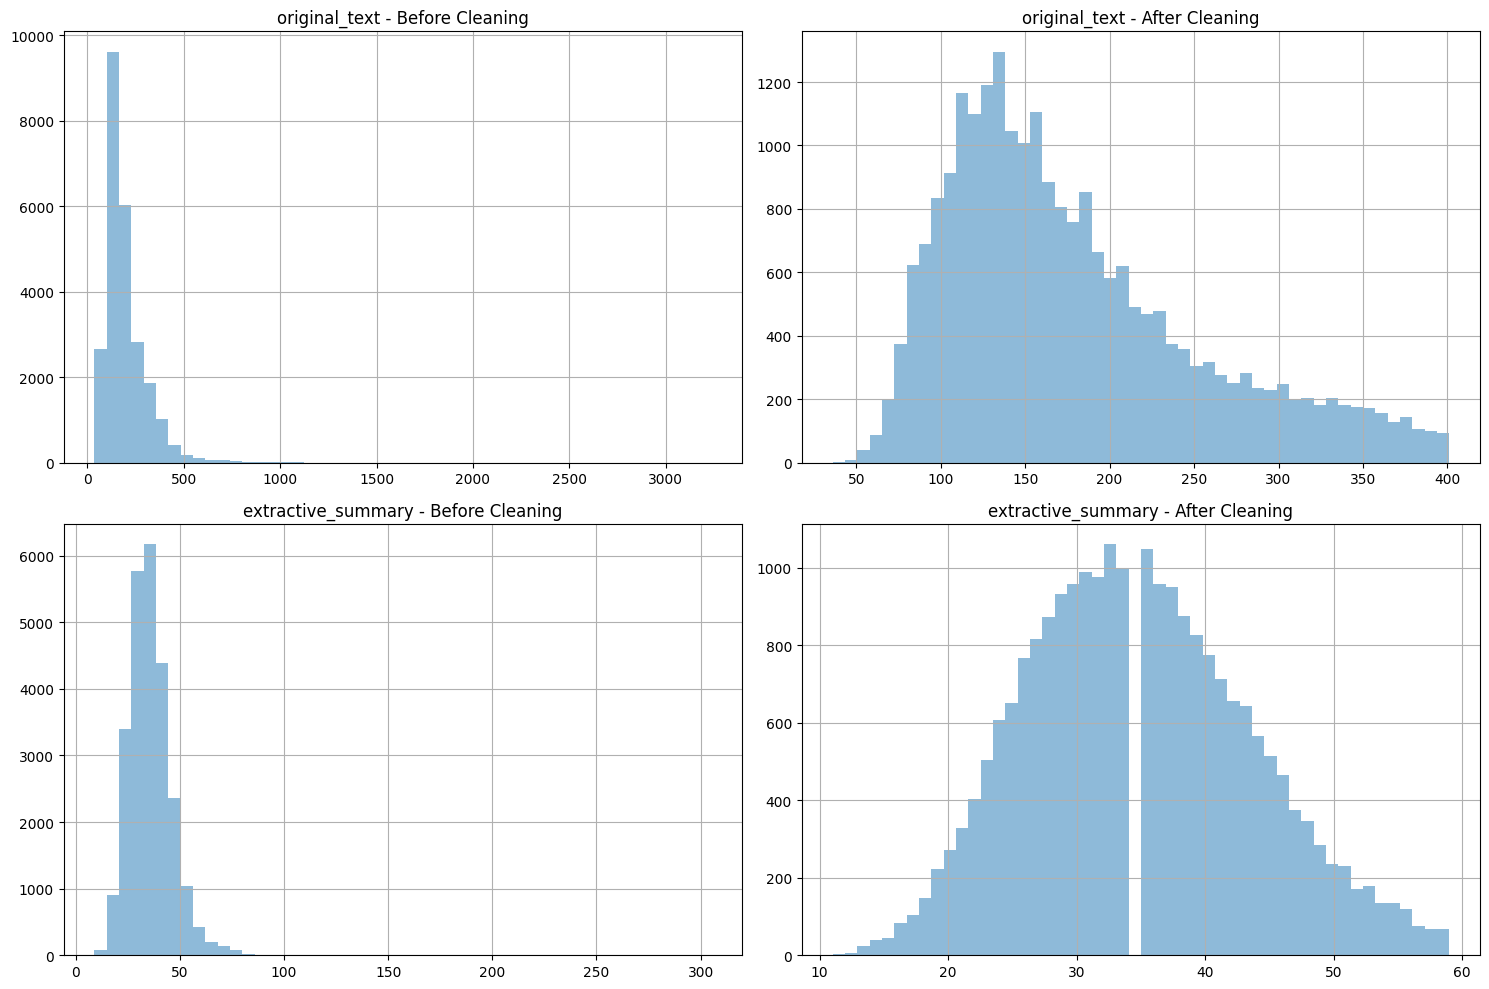

Dev Dataset


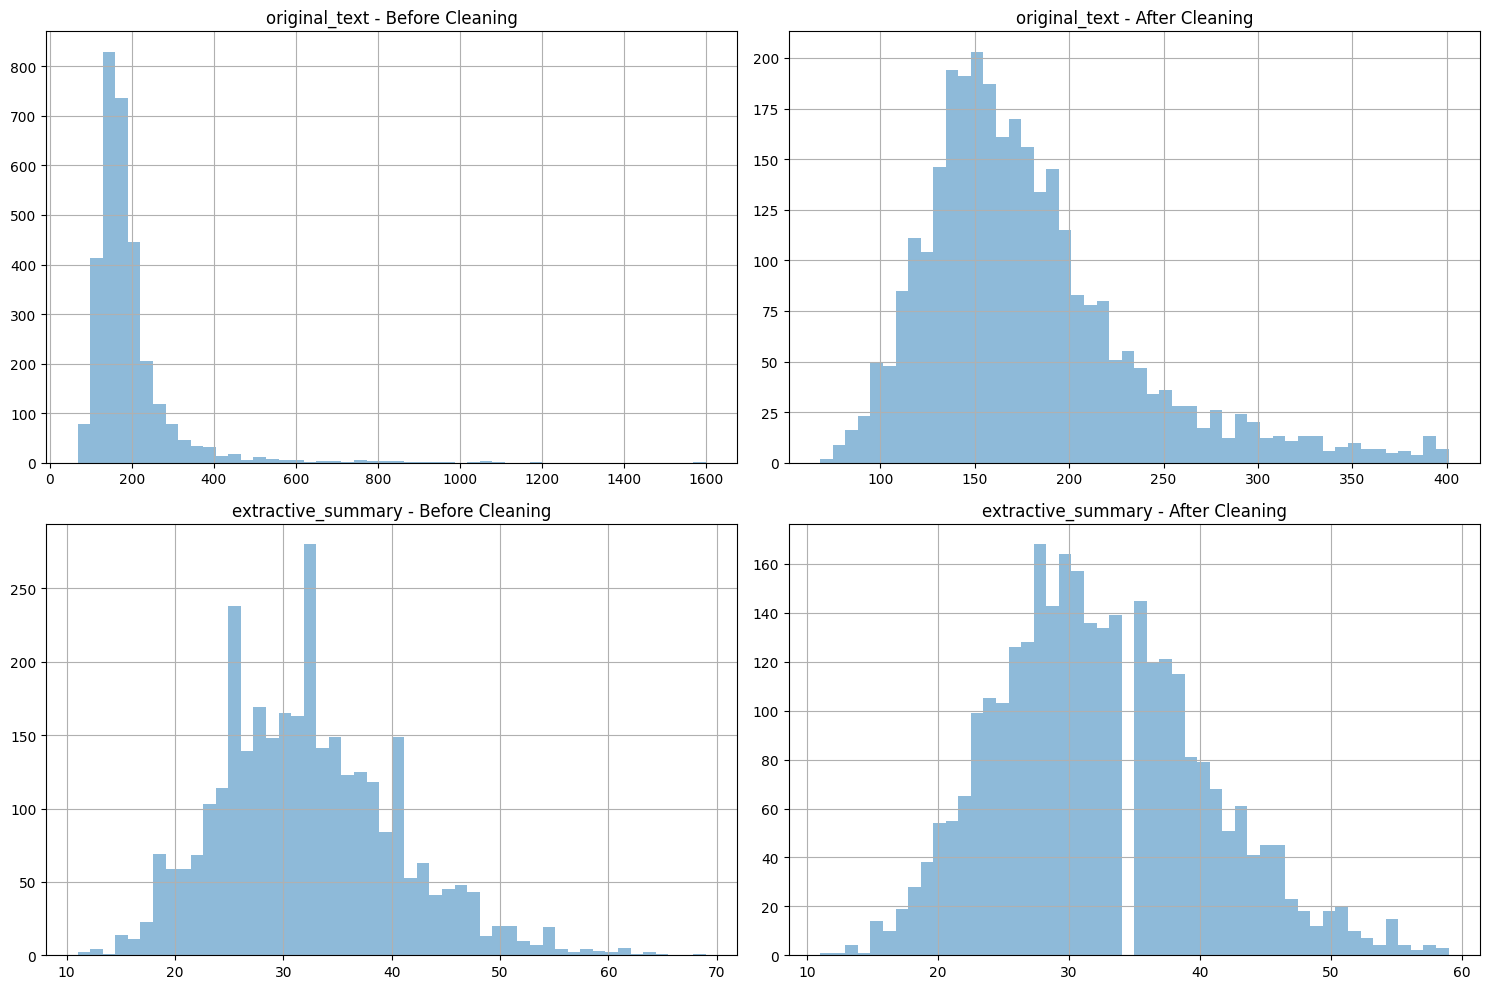

Test Dataset


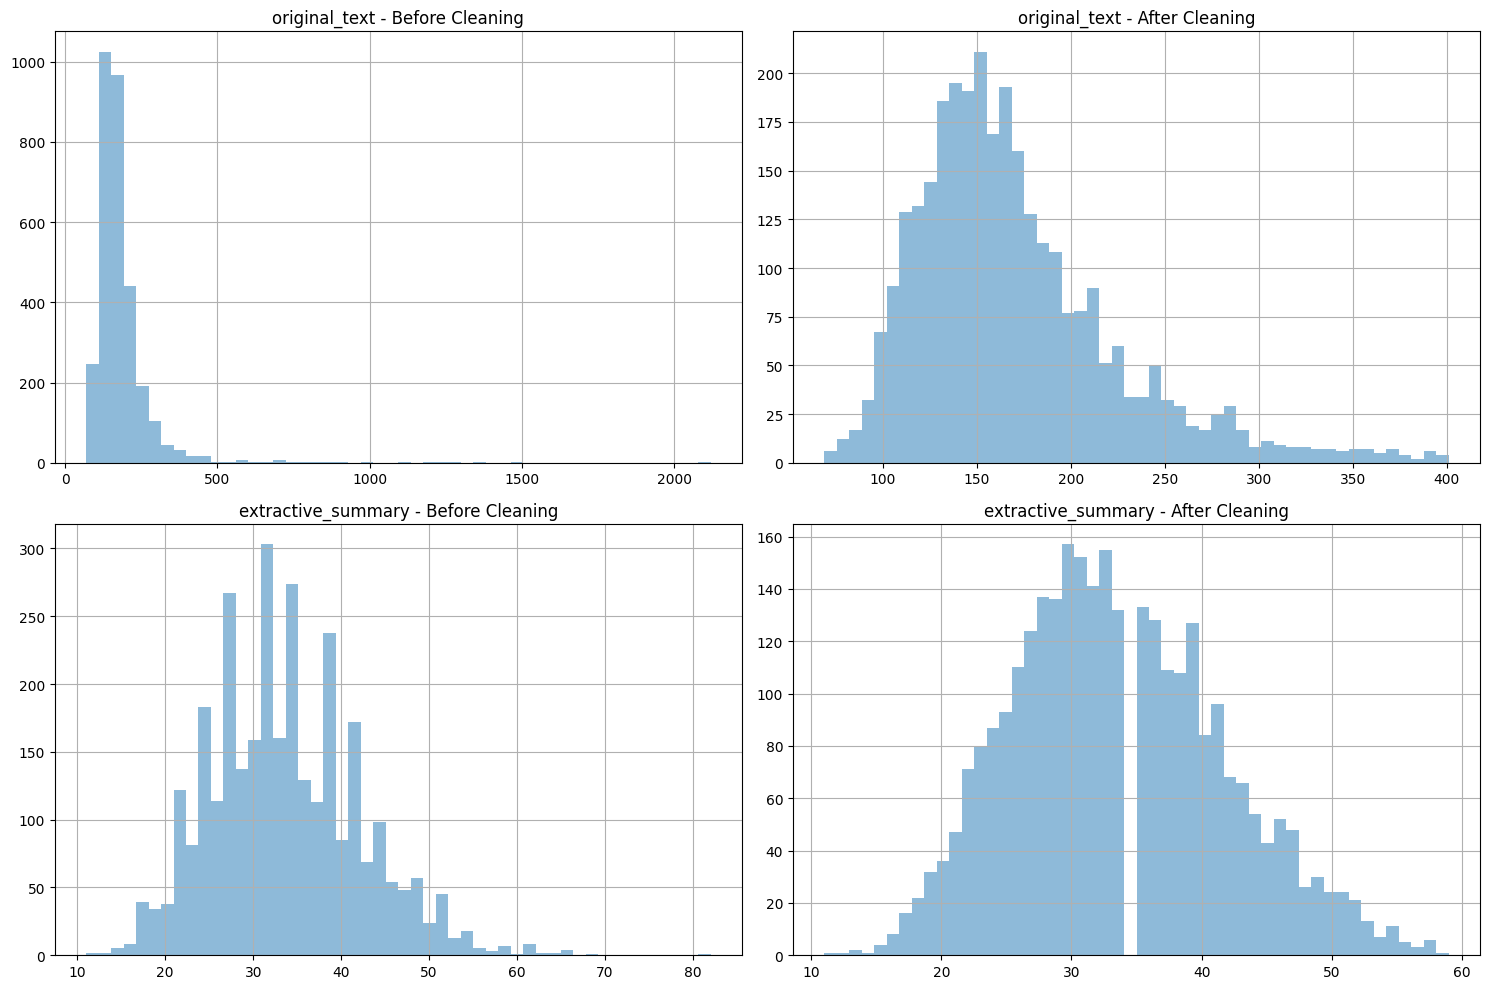

In [72]:
columns_to_check = ['original_text', 'extractive_summary']

train_bounds = compute_outlier_bounds_from_df(sample_train_df, columns_to_check)

clean_sample_train_df, train_outliers = apply_outlier_filter(sample_train_df, columns_to_check, train_bounds)
clean_sample_dev_df, dev_outliers = apply_outlier_filter(sample_dev_df, columns_to_check, train_bounds)
clean_sample_test_df, test_outliers = apply_outlier_filter(sample_test_df, columns_to_check, train_bounds)

print(f"Train original: {sample_train_df.shape}, Cleaned: {clean_sample_train_df.shape}, Removed: {len(train_outliers)}")
print(f"Dev original: {sample_dev_df.shape}, Cleaned: {clean_sample_dev_df.shape}, Removed: {len(dev_outliers)}")
print(f"Test original: {sample_test_df.shape}, Cleaned: {clean_sample_test_df.shape}, Removed: {len(test_outliers)}")

print(f"Train Dataset")
plot_word_distributions(sample_train_df, clean_sample_train_df, columns_to_check)
print(f"Dev Dataset")
plot_word_distributions(sample_dev_df, clean_sample_dev_df, columns_to_check)
print(f"Test Dataset")
plot_word_distributions(sample_test_df, clean_sample_test_df, columns_to_check)

In [73]:
clean_sample_train_df.to_csv('train_df.csv', encoding = 'utf-8-sig')
files.download('train_df.csv')

clean_sample_dev_df.to_csv('dev_df.csv', encoding = 'utf-8-sig')
files.download('dev_df.csv')

clean_sample_test_df.to_csv('test_df.csv', encoding = 'utf-8-sig')
files.download('test_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>